In [1]:
#a1
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval().to(device)

def extract_features_from_folder(folder_path):
    features = []
    for img_name in tqdm(os.listdir(folder_path)):
        if img_name.endswith((".png", ".jpg", ".jpeg")):
            try:
                img_path = os.path.join(folder_path, img_name)
                image = Image.open(img_path).convert('RGB')
                image = transform(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    output = resnet(image)
                vector = output.squeeze().cpu().numpy()
                features.append(vector)
            except:
                continue
    return np.array(features)

class_A_features = extract_features_from_folder("data_A")
class_B_features = extract_features_from_folder("data_B")

centroid_A = np.mean(class_A_features, axis=0)
centroid_B = np.mean(class_B_features, axis=0)

spread_A = np.std(class_A_features, axis=0)
spread_B = np.std(class_B_features, axis=0)

interclass_distance = np.linalg.norm(centroid_A - centroid_B)

print("Class A centroid shape:", centroid_A.shape)
print("Class B centroid shape:", centroid_B.shape)
print("\nClass A Spread (STD):", np.round(np.mean(spread_A), 4))
print("Class B Spread (STD):", np.round(np.mean(spread_B), 4))
print("\nInterclass Distance (Euclidean between centroids):", np.round(interclass_distance, 4))


C:\Users\Taduri Abhi Chakra\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Taduri Abhi Chakra\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [14:24<00:00,  2.17it/s]

Class A centroid shape: (512,)
Class B centroid shape: (512,)

Class A Spread (STD): 0.3853
Class B Spread (STD): 0.4132

Interclass Distance (Euclidean between centroids): 3.2281


Mean of DR: 0.20
Variance of DR: 0.16


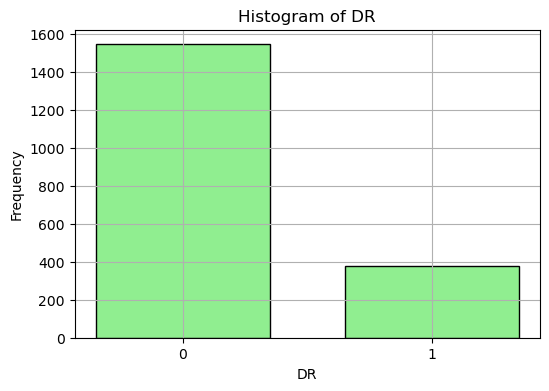

In [3]:
#a2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("RFMiD_Training_Labels.csv")

feature_column = 'DR'

data = df[feature_column].dropna()

mean_val = np.mean(data)
var_val = np.var(data)

print(f"Mean of {feature_column}: {mean_val:.2f}")
print(f"Variance of {feature_column}: {var_val:.2f}")

plt.figure(figsize=(6,4))
plt.hist(data, bins=[-0.5, 0.5, 1.5], edgecolor='black', color='lightgreen', rwidth=0.7)
plt.xticks([0, 1])
plt.title(f"Histogram of {feature_column}")
plt.xlabel(feature_column)
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


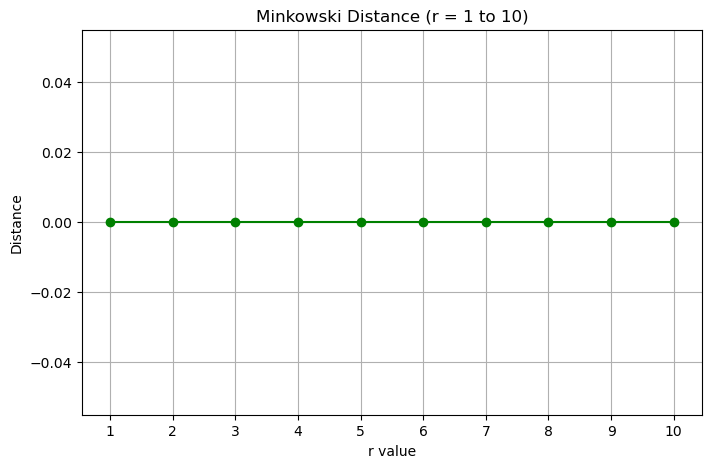

In [12]:
#a3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import minkowski

df = pd.read_csv("RFMiD_Training_Labels.csv")

features = ['DR', 'ARMD', 'MH', 'DN', 'MYA']
vector1 = df.loc[0, features].to_numpy()
vector2 = df.loc[1, features].to_numpy()

r_values = list(range(1, 11))
distances = [minkowski(vector1, vector2, p=r) for r in r_values]

plt.figure(figsize=(8, 5))
plt.plot(r_values, distances, marker='o', linestyle='-', color='green')
plt.title("Minkowski Distance (r = 1 to 10)")
plt.xlabel("r value")
plt.ylabel("Distance")
plt.grid(True)
plt.xticks(r_values)
plt.show()


In [11]:
#a4
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("RFMiD_Training_Labels.csv")

filtered_df = df[((df['DR'] == 1) & (df['ARMD'] == 0)) | ((df['DR'] == 0) & (df['ARMD'] == 1))].copy()

filtered_df['Label'] = filtered_df['ARMD']

X = filtered_df.drop(columns=['ID', 'Label'])
y = filtered_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (333, 46)
Testing features shape: (143, 46)
Training labels shape: (333,)
Testing labels shape: (143,)


In [14]:
#a5
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("RFMiD_Training_Labels.csv")

filtered_df = df[(df['ARMD'] == 1) | (df['ARMD'] == 0)].copy()

filtered_df['Label'] = filtered_df['ARMD']

features = ['DR', 'ARMD', 'MH', 'DN', 'MYA']
X = filtered_df[features]
y = filtered_df['Label']
# Split into training and testing sets (70% train, 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train kNN with k=3
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00        32

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [15]:
#a6
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

dataframe = pd.read_csv("RFMiD_Training_Labels.csv")
filtered_dataframe = dataframe[(dataframe['ARMD'] == 1) | (dataframe['ARMD'] == 0)].copy()
filtered_dataframe['Label'] = filtered_dataframe['ARMD']

feature_columns = ['DR', 'ARMD', 'MH', 'DN', 'MYA']
input_features = filtered_dataframe[feature_columns]
output_labels = filtered_dataframe['Label']

input_features_train, input_features_test, output_labels_train, output_labels_test = train_test_split(input_features, output_labels, test_size=0.3, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(input_features_train, output_labels_train)

predicted_labels = knn_classifier.predict(input_features_test)

print("Accuracy:", accuracy_score(output_labels_test, predicted_labels))
print("\nClassification Report:\n", classification_report(output_labels_test, predicted_labels))
print("\nScore using test data:", knn_classifier.score(input_features_test, output_labels_test))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00        32

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576


Score using test data: 1.0


In [19]:
#a7
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("RFMiD_Training_Labels.csv")

df_filtered = df[(df['ARMD'] == 1) | (df['ARMD'] == 0)].copy()

feature_columns = ['DR', 'MH', 'DN', 'MYA']
X = df_filtered[feature_columns]
y = df_filtered['ARMD'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

all_preds = neigh.predict(X_test)
print("Predicted labels for test set:\n", all_preds)

test_vector = X_test.iloc[[4]]  

predicted_class = neigh.predict(test_vector)
print("\nPredicted class for a single test vector (5th row):", predicted_class[0])


Predicted labels for test set:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Accuracy for k = 1: 0.9444
Accuracy for k = 3: 0.9444


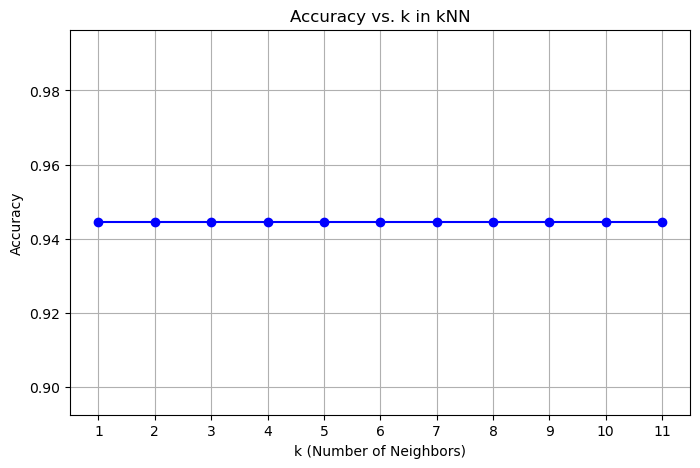

In [20]:
#a8
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv("RFMiD_Training_Labels.csv")
df_filtered = df[(df['ARMD'] == 1) | (df['ARMD'] == 0)].copy()

features = ['DR', 'MH', 'DN', 'MYA']
X = df_filtered[features]
y = df_filtered['ARMD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k_values = range(1, 12)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    if k == 1 or k == 3:
        print(f"Accuracy for k = {k}: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', color='blue', linestyle='-')
plt.title("Accuracy vs. k in kNN")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()


Training Confusion Matrix:
 [[1276    0]
 [  68    0]]

Training Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1276
           1       0.00      0.00      0.00        68

    accuracy                           0.95      1344
   macro avg       0.47      0.50      0.49      1344
weighted avg       0.90      0.95      0.92      1344

Testing Confusion Matrix:
 [[544   0]
 [ 32   0]]

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       544
           1       0.00      0.00      0.00        32

    accuracy                           0.94       576
   macro avg       0.47      0.50      0.49       576
weighted avg       0.89      0.94      0.92       576



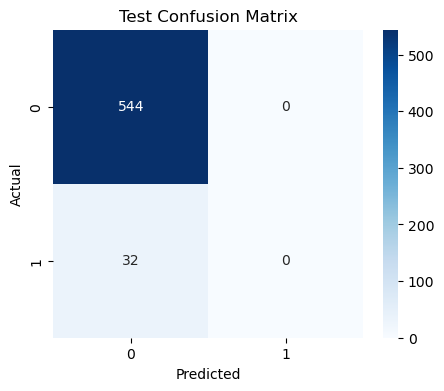

In [23]:
#a9
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("RFMiD_Training_Labels.csv")
df_filtered = df[(df['ARMD'] == 1) | (df['ARMD'] == 0)].copy()

features = ['DR', 'MH', 'DN', 'MYA']
X = df_filtered[features]
y = df_filtered['ARMD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

train_cm = confusion_matrix(y_train, train_pred)
print("Training Confusion Matrix:\n", train_cm)
print("\nTraining Classification Report:\n", classification_report(y_train, train_pred, zero_division=0))

test_cm = confusion_matrix(y_test, test_pred)
print("Testing Confusion Matrix:\n", test_cm)
print("\nTesting Classification Report:\n", classification_report(y_test, test_pred, zero_division=0))

plt.figure(figsize=(5,4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
